In [1]:
from sklearn.ensemble import AdaBoostRegressor,GradientBoostingRegressor, RandomForestRegressor, StackingRegressor
from sklearn.ensemble import AdaBoostClassifier,GradientBoostingClassifier, RandomForestClassifier, StackingClassifier

from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

from sklearn.linear_model import RidgeCV
from sklearn.datasets import make_regression
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import pdb
# X, y = make_regression(n_features=4 n_informative=2,random_state=0, shuffle=False)

In [2]:
def classify_to_label(y,data_bin):
    

    n_bin = len(data_bin) - 1 

    # Categorizing Target Variable
    for i in range(len(data_bin)-1):
        if data_bin[i]<=y and data_bin[i+1]>y:
            break

    class_label = i
    
    return class_label

In [3]:
# load data

def load_data(data_dir,city_name,selected_idx,label_idx):
    
    data_bin = [0,8,16,24,32,40]

    if city_name == 'FL':
        data_bin = [0.0, 7.90, 15.79, 23.69, 31.59, 39.48]
    elif city_name == 'NY':
        data_bin = [0.0, 8.0, 15.99, 23.99, 31.99, 39.98]
    elif city_name == 'CA':
        data_bin = [0.0, 9.66, 19.31, 28.97, 38.63, 48.28]
    
    
    train_data = np.load('{0}/{1}/train.npy'.format(data_dir,city_name),allow_pickle = True)
    test_data = np.load('{0}/{1}/test.npy'.format(data_dir,city_name),allow_pickle = True)

    X_train_raw = train_data[:,selected_idx]
    X_test_raw = test_data[:,selected_idx]

    y_train = train_data[:,label_idx]
    y_train = np.array([ classify_to_label(x,data_bin) for x in y_train])
    y_test = test_data[:,label_idx]
    y_test = np.array([ classify_to_label(x,data_bin) for x in y_test])


    # Standardizing data

    scaler = StandardScaler()
    scaler.fit(X_train_raw)
    X_train = scaler.transform(X_train_raw)
    X_test = scaler.transform(X_test_raw)
    
    return X_train,X_test,y_train,y_test


def simulate_classifier(data_dir,src_city_name,tgt_city_name,method):
    
    
    selected_idx = np.array(list(set(range(15)) - set(list(range(5))+[8,10,11,14])))
    label_idx = 15
    
    X_train_src,X_test_src,y_train_src,y_test_src = load_data(data_dir,src_city_name,selected_idx,label_idx)

    
    if method=='AdaboostClassifier':
        regr = AdaBoostClassifier(n_estimators=1000, learning_rate = 1e-3)
        
    elif method=='GradientBoostingClassifier':
        regr = GradientBoostingClassifier(n_estimators=1000,  learning_rate=1e-3)
        
    elif method=='RandomForestClassifier':
        regr = RandomForestClassifier(max_depth=2, random_state=0)
        
    elif method=='StackingClassifier':  
        
        estimators = [('rf', RandomForestClassifier(n_estimators=10, random_state=42)),
                      ('svr', make_pipeline(StandardScaler(),LinearSVC(dual="auto", random_state=42)))]
        
        regr = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
        
#         estimators = [('lr', RidgeCV()),('svr', LinearSVR())]
#         regr = StackingRegressor(estimators=estimators,final_estimator=RandomForestRegressor(n_estimators=1000,random_state=42))

#         estimators = [('lr', RidgeCV()),('svr', LinearSVR())]
#         regr = StackingClassifier(estimators=estimators,final_estimator=RandomForestRegressor(n_estimators=1000,random_state=42))

        
        
    print('Method: ',method) 
        
    regr.fit(X_train_src,y_train_src)
    pred = regr.predict(X_test_src)
    
    
    acc = np.sum(pred == y_test_src)*100/(y_test_src.shape[0])
    
    print('Acc src {0}%: '.format(src_city_name),acc) 
    
    for j in range(len(tgt_city_name)):
        X_train_tgt,X_test_tgt,y_train_tgt,y_test_tgt = load_data(data_dir,tgt_city_name[j],selected_idx,label_idx)
        pred = regr.predict(X_test_tgt)
        acc = np.sum(pred == y_test_tgt)*100/(y_test_tgt.shape[0])
        
        print('Acc tgt {0} %: '.format(tgt_city_name[j]),acc) 

In [32]:
data_dir = 'data'

city = ['CA', 'NY', 'FL']


for i in range(1):
    
        src_city_name = city[i]

        simulate_classifier(data_dir,src_city_name,city,method='AdaboostClassifier')
        simulate_classifier(data_dir,src_city_name,city,method='GradientBoostingClassifier')
        simulate_classifier(data_dir,src_city_name,city,method='RandomForestClassifier')
#         simulate_classifier(data_dir,src_city_name,city,method='StackingClassifier')



Method:  AdaboostClassifier
Acc src CA%:  76.65525114155251
Acc tgt CA %:  76.65525114155251
Acc tgt NY %:  68.57876712328768
Acc tgt FL %:  67.75114155251141
Method:  GradientBoostingClassifier
Acc src CA%:  78.99543378995433
Acc tgt CA %:  78.99543378995433
Acc tgt NY %:  73.14497716894977
Acc tgt FL %:  70.662100456621
Method:  RandomForestClassifier
Acc src CA%:  76.71232876712328
Acc tgt CA %:  76.71232876712328
Acc tgt NY %:  68.77853881278538
Acc tgt FL %:  67.92237442922375


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


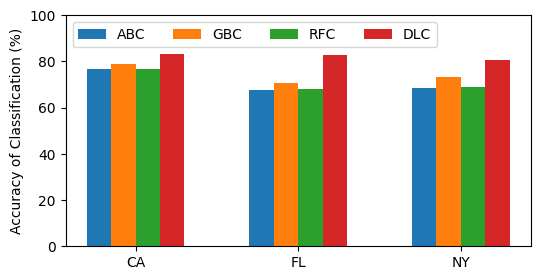

In [10]:
import matplotlib.pyplot as plt
import numpy as np

species = ("CA", "FL","NY")
penguin_means = {
    'ABC': (76.65, 67.75, 68.57),    
    'GBC': (78.995, 70.66,  73.14),   
    'RFC': (76.71, 67.922, 68.778),
    'DLC': (83.43,82.99,80.59)

}

x = np.arange(len(species))  # the label locations
width = 0.15  # the width of the bars
multiplier = -0.5

# fig, ax = plt.subplots(layout='constrained')
fig, ax = plt.subplots()
plt.rcParams['savefig.facecolor'] = "0.8"
plt.rcParams['figure.figsize'] = 6, 3.
plt.rcParams['figure.max_open_warning'] = 100

for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
#     ax.bar_label(rects, padding=0)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy of Classification (%)')
# ax.set_title('Comparison of different methods on target domain')
ax.set_xticks(x + width, species)
ax.legend(loc='upper left', ncols=4)
ax.set_ylim(0, 100)
plt.savefig('test.eps', dpi=300, bbox_inches='tight')
# plt.show()

In [ ]:
Method:  Adaboost
MSE src Dhaka:  96.7630144448639
MSE tgt Dhaka:  96.7630144448639
MSE tgt Paris:  207.64458207121433
MSE tgt Los_Angeles:  259.3617824119218
MSE tgt Tokyo:  126.30593212094226
Method:  GradientBoostingRegressor
MSE src Dhaka:  102.78577788384965
MSE tgt Dhaka:  102.78577788384965
MSE tgt Paris:  97.92940207926726
MSE tgt Los_Angeles:  105.5716964888382
MSE tgt Tokyo:  74.00414143351324
Method:  RandomForestRegressor
MSE src Dhaka:  85.82521626217928
MSE tgt Dhaka:  85.82521626217928
MSE tgt Paris:  428.0064787676169
MSE tgt Los_Angeles:  466.9881873200548
MSE tgt Tokyo:  258.52703080851774
Method:  StackingRegressor
MSE src Dhaka:  112.32889830103083
MSE tgt Dhaka:  112.32889830103083
MSE tgt Paris:  1954.0485385078514
MSE tgt Los_Angeles:  761.9855680207588
MSE tgt Tokyo:  719.9933939502806
Method:  Adaboost
MSE src Paris:  7.767552861749437
MSE tgt Dhaka:  149.98616707252685
MSE tgt Paris:  7.767552861749437
MSE tgt Los_Angeles:  14.7444781215056
MSE tgt Tokyo:  87.11789674589657
Method:  GradientBoostingRegressor
MSE src Paris:  8.173960107125785
MSE tgt Dhaka:  154.40513073981356
MSE tgt Paris:  8.173960107125785
MSE tgt Los_Angeles:  13.973550830850337
MSE tgt Tokyo:  89.77438076644468
Method:  RandomForestRegressor
MSE src Paris:  5.919542255846407
MSE tgt Dhaka:  131.03907672846736
MSE tgt Paris:  5.919542255846407
MSE tgt Los_Angeles:  17.432068970611635
MSE tgt Tokyo:  76.18953076766276
Method:  StackingRegressor
/home/araf/anaconda3/envs/power/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/araf/anaconda3/envs/power/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/araf/anaconda3/envs/power/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/araf/anaconda3/envs/power/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
MSE src Paris:  7.738129936549004
MSE tgt Dhaka:  137.90261601516713
MSE tgt Paris:  7.738129936549004
MSE tgt Los_Angeles:  16.951054886464274
MSE tgt Tokyo:  79.6910470978365
Method:  Adaboost
MSE src Los_Angeles:  4.023661793080969
MSE tgt Dhaka:  181.02893562214476
MSE tgt Paris:  13.359565403825838
MSE tgt Los_Angeles:  4.023661793080969
MSE tgt Tokyo:  86.66761633688206
Method:  GradientBoostingRegressor
MSE src Los_Angeles:  5.0953926868241854
MSE tgt Dhaka:  178.27911020880185
MSE tgt Paris:  12.3575269988873
MSE tgt Los_Angeles:  5.0953926868241854
MSE tgt Tokyo:  89.83232437408496
Method:  RandomForestRegressor
MSE src Los_Angeles:  3.483459142017387
MSE tgt Dhaka:  157.21003034342888
MSE tgt Paris:  11.718117276894667
MSE tgt Los_Angeles:  3.483459142017387
MSE tgt Tokyo:  73.40957673101335
Method:  StackingRegressor
/home/araf/anaconda3/envs/power/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/araf/anaconda3/envs/power/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/araf/anaconda3/envs/power/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/araf/anaconda3/envs/power/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/araf/anaconda3/envs/power/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/araf/anaconda3/envs/power/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
MSE src Los_Angeles:  5.359338324573942
MSE tgt Dhaka:  114.87203526093208
MSE tgt Paris:  33.593652441037605
MSE tgt Los_Angeles:  5.359338324573942
MSE tgt Tokyo:  72.66929542402227
Method:  Adaboost
MSE src Tokyo:  49.33630502607157
MSE tgt Dhaka:  130.59576155263764
MSE tgt Paris:  28.18866868784084
MSE tgt Los_Angeles:  31.098093209385386
MSE tgt Tokyo:  49.33630502607157
Method:  GradientBoostingRegressor
MSE src Tokyo:  52.39609381931485
MSE tgt Dhaka:  129.55852089122598
MSE tgt Paris:  17.66315945241389
MSE tgt Los_Angeles:  19.05404122744288
MSE tgt Tokyo:  52.39609381931485
Method:  RandomForestRegressor
MSE src Tokyo:  40.39270874816319
MSE tgt Dhaka:  106.86054891042201
MSE tgt Paris:  30.420518063285208
MSE tgt Los_Angeles:  41.03662472384906
MSE tgt Tokyo:  40.39270874816319
Method:  StackingRegressor
MSE src Tokyo:  59.53631651425546
MSE tgt Dhaka:  485.20802891193375
MSE tgt Paris:  281.6091640541753
MSE tgt Los_Angeles:  1506.7838162494756
MSE tgt Tokyo:  59.53631651425546

In [27]:
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import StackingClassifier
X, y = load_iris(return_X_y=True)
estimators = [('rf', RandomForestClassifier(n_estimators=10, random_state=42)),('svr', make_pipeline(StandardScaler()))]
clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

In [28]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
clf.fit(X_train, y_train).score(X_test, y_test)

ValueError: The estimator Pipeline should be a classifier.